1. 앞 120경기로 후 20경기 예측

2. 앞 120경기를 20경기씩 6묶음으로 묶어서 후 20경기 예측

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. 데이터 가져오기

In [4]:
t_bat16=pd.read_csv("C:/Users/a/Desktop/2020빅콘/제공데이터/제공데이터(.CSV)_시즌별, 시트별 구분/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2016.csv",encoding='utf-8',engine='python')
t_bat17=pd.read_csv("C:/Users/a/Desktop/2020빅콘/제공데이터/제공데이터(.CSV)_시즌별, 시트별 구분/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2017.csv",encoding='utf-8',engine='python')
t_bat18=pd.read_csv("C:/Users/a/Desktop/2020빅콘/제공데이터/제공데이터(.CSV)_시즌별, 시트별 구분/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2018.csv",encoding='utf-8',engine='python')
t_bat19=pd.read_csv("C:/Users/a/Desktop/2020빅콘/제공데이터/제공데이터(.CSV)_시즌별, 시트별 구분/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2019.csv",encoding='utf-8',engine='python')

In [5]:
#모든 열 다 출력하기
pd.options.display.max_columns=None

## 2. train test 셋 만들기

In [6]:
team=['HH', 'HT', 'KT', 'LG', 'LT', 'NC', 'OB', 'SK', 'SS', 'WO']

In [7]:
def make_data(train,answer):
    train['HIT_RATE']=train['HIT']/train['AB']
    tr=train[['T_ID','HIT_RATE']]  #경기당 팀과 타율만 남김
    num=list(range(1,int((len(train)/10)+1)))*10  #팀별 경기순서 추가
    tr=tr.assign(order=num)
    tr=tr.pivot(index='T_ID',columns='order',values='HIT_RATE') #팀당 경기별 타율 데이터셋 만들기
    
    data=pd.merge(tr,answer,on='T_ID') #팀별 앞124경기와 후20경기 결과 합치기
    return data

In [66]:
#정답 셋과 train 셋 만드는 함수
t_bat=[t_bat16,t_bat17,t_bat18,t_bat19]
def make_answer_train(year):
    a=t_bat[year-2016][['T_ID','AB','HIT']][140:]  #각 팀당 앞 14경기 버리기
    data=pd.DataFrame()  #빈 데이터프레임 만들기

    train_name=['train' + str(i) for i in range(1,5)]
    train=[pd.DataFrame() for var in train_name] #50경기씩 묶일 데이터셋
    
    ans_name=['ans' + str(i) for i in range(1,5)]
    answer=[pd.DataFrame() for var in ans_name]  #20경기씩 묶일 데이터셋
    
    data_name=['data' + str(i) for i in range(1,5)]
    
    for i in range(4):
        tra=train[i]
        ans=answer[i]
        for t in team:
            tra=pd.concat([tra,a[a['T_ID']==t][i*20:50+i*20]])
            ans=pd.concat([ans,a[a['T_ID']==t][50+i*20:70+i*20]])

        #팀별 AB,HIT합 구하기
        ans=ans.groupby(['T_ID']).sum()
        ans['HIT_RATE']=ans['HIT']/ans['AB'] #타율 계산
        ans=ans.drop(ans.columns[[0,1]],axis='columns')

        if i <3:
            d=make_data(tra,ans)
            data=pd.concat([data,d])
        else:
            test=make_data(tra,ans)
        
    return data,test

In [68]:
train16,test16=make_answer_train(2016)
train17,test17=make_answer_train(2017)
train18,test18=make_answer_train(2018)
train19,test19=make_answer_train(2019)

## 3. 모델학습

In [69]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [70]:
# 모델 모듈
import xgboost
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [72]:
X_cols=list(range(1,51))
Y_col=['HIT_RATE']

In [74]:
#### 학습시킬 모델
model_dict = {'xgb':XGBRegressor(n_estimators=100, learning_rate=0.05 ,max_depth=3, random_state=23),
    'lgbm':LGBMRegressor(),
    'rf':RandomForestRegressor(),
    'svr':SVR(),
    'reg':LinearRegression(),
    'ridge':Ridge(),
    'lasso':Lasso()}

In [110]:
train=train16
test=test16

In [127]:
X_train = train[X_cols]
Y_train = train[Y_col]

X_test = test[X_cols]
Y_test = test[Y_col]

model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
#weight = train['17_HIT_RATE']
#model.fit(X_train, Y_train, sample_weight=weight)
model.fit(X_train, Y_train)  #가중치 제거
Y_predict = model.predict(X_test)

#test_error=mean_squared_error(Y_test, Y_predict, sample_weight=X_test['17_HIT_RATE']) ** 0.5
test_error=mean_squared_error(Y_test, Y_predict) ** 0.5  #가중치 제거
r2=r2_score(Y_test, Y_predict)
    
print("test error : ", test_error)
print("r2 : ", r2)

test error :  0.013317199121878565
r2 :  0.30393488887027387


1.xgb > 
test error :  0.034645487302268914
r2 :  -2.2041863372750212

2. lgbm > 
test error :  0.024255481057295004
r2 :  -0.5705226369343803

3. rf > 
test error :  0.027348058385408155
r2 :  -0.9965372280251992

4. svr > 
test error :  0.02755574849536312
r2 :  -1.0269770908040021

5. reg > 
test error :  0.034186874825641325
r2 :  -2.1199182852069756

6. ridge > 
test error :  0.025524426712018357
r2 :  -0.7391474675076914

7. lasso > 
test error :  0.024255481966177092
r2 :  -0.5705227546331315


### 예측값과 실제값 차이

Text(0,0.5,'예측 값')

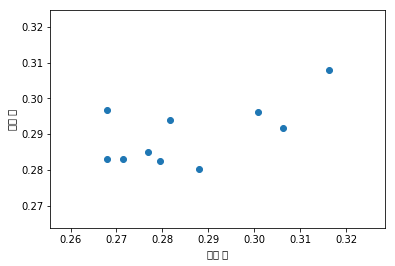

In [128]:
# 예측값과 실제값의 시각화
plt.scatter(Y_test, Y_predict)
plt.xlabel("실제 값")
plt.ylabel("예측 값")

In [129]:
#예측값과 실제값 차이
a=Y_test
a=a.assign(predict=Y_predict)
a['diff']=abs(a['HIT_RATE']-a['predict'])
a

,HIT_RATE,predict,diff
T_ID,,,
HH,0.276878,0.284849,0.007971
HT,0.279522,0.282377,0.002856
KT,0.287879,0.280325,0.007554
LG,0.267908,0.283095,0.015187
LT,0.300699,0.296181,0.004519
NC,0.271408,0.283025,0.011617
OB,0.316216,0.308033,0.008183
SK,0.281690,0.293888,0.012198
SS,0.306207,0.291685,0.014522


In [130]:
#차이 합
a['diff'].sum()

0.1134515269919869